In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium
import cookiedisaster

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        # buffer uses deque for FIFO operations
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        # append the transition to deque; if the buffer is full, the oldest transition is automatically removed
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        # randomly sample batch_size elements from the buffer
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state)

    def __len__(self):
        return len(self.buffer)

In [4]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions)
        )

    def forward(self, state):
        return self.network(state)

In [5]:
class DQNAgent:
    def __init__(self, input_dim, action_space, buffer_size=1000000, batch_size=64, update_target_every=1000):
        self.policy_net = DQN(input_dim, action_space)
        self.target_net = DQN(input_dim, action_space)
        # copy the weights from the policy network to the target network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        # replay buffer to store transitions
        self.buffer = ReplayBuffer(buffer_size)
        # batch size for sampling from the buffer
        self.batch_size = batch_size
        # how often to update the target network
        self.update_target_every = update_target_every
        # counter to keep track of when to update the target network
        self.step_count = 0
        self.evaluation_mode = False  # flag for evaluation mode

    def set_evaluation_mode(self, mode=True):
        # set the agent to evaluation mode, so that now agent.select_action(state) will always choose the best action
        self.evaluation_mode = mode

    def select_action(self, state):
        # if not in evaluation mode and random number is below epsilon, choose random action
        if not self.evaluation_mode and np.random.rand() < self.epsilon:
            return np.random.randint(0, self.policy_net.network[-1].out_features)
        # otherwise, compute the Q-values for the current state and choose the action with the highest Q-value
        else:
            state = torch.FloatTensor([state])
            q_values = self.policy_net(state)
            return torch.argmax(q_values).item()

    def train(self, state, action, reward, next_state):
        # store the transition in the replay buffer
        self.buffer.push(state, action, reward, next_state)

        # only start training if the buffer has enough samples
        if len(self.buffer) < self.batch_size:
            return

        # sample a batch of transitions from the buffer
        states, actions, rewards, next_states = self.buffer.sample(self.batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)

        # compute the current Q-values and the next Q-values
        current_q = self.policy_net(states).gather(1, actions).squeeze(1)
        next_q = self.target_net(next_states).max(1)[0]
        expected_q = rewards + self.gamma * next_q

        # compute the loss and perform a gradient descent step
        loss = nn.MSELoss()(current_q, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        # periodically update the target network
        if self.step_count % self.update_target_every == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self):
        torch.save(self.policy_net.state_dict(), "policy_net.pth")

    def load(self):
        policy_net_state_dict = torch.load("policy_net.pth")
        self.policy_net.load_state_dict(policy_net_state_dict)
        self.target_net.load_state_dict(policy_net_state_dict)

In [6]:
def get_features(obs, info):
    agent_pos = obs["agent"]["pos"]
    agent_vel = obs["agent"]["vel"]
    cookie_pos = obs["cookie"]["pos"]
    cookie_time = obs["cookie"]["time"]
    dist = info["distance"]

    return [agent_pos, agent_vel, cookie_pos, cookie_time, dist]

In [7]:
def randomize_environment():
    images = ["cookie", "cake", "scone"]
    width_range = (1, 30)
    lifetime_range = (1, 15)
    friction_coefficient_range = (0.0001, 0.2)

    # generate random configuration
    config = {
        "img": random.choice(images),
        "width": np.random.randint(*width_range),
        "lifetime": np.random.randint(*lifetime_range),
        "friction": lambda vel: - abs(vel) * vel * np.random.uniform(*friction_coefficient_range)
    }

    # create and return the environment with the random configuration
    env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array", config=config)
    return env

Data Collection for Normalization

In [ ]:
num_envs = 10000
num_steps = 5000
observation_examples = []

for e in range(num_envs):
    env = randomize_environment()
    obs, _ = env.reset()
    for s in range(num_steps):
        action = env.action_space.sample()  # random policy
        next_obs, _, _, _, info = env.step(action)
        observation_examples.append(get_features(next_obs, info))

In [ ]:
observation_examples = np.array(observation_examples)

In [ ]:
scaler = StandardScaler()
scaler.fit(observation_examples)

np.save("scaler_mean.npy", scaler.mean_)
np.save("scaler_std.npy", scaler.scale_)

Data Normalization Using Precomputed Mean and Standard Deviation

In [8]:
scaler_mean = np.load("scaler_mean.npy")
scaler_std = np.load("scaler_std.npy")


def normalize(data, mean=scaler_mean, std=scaler_std):
    return (data - mean) / std

In [9]:
env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")

n_observations = len(get_features(*env.reset()))
n_actions = env.action_space.n

agent = DQNAgent(n_observations, n_actions)

In [10]:
def train_agent(agent, num_episodes=1000, max_steps_per_episode=2000):
    episode_rewards = []
    episode_items_collected = []

    for episode in range(num_episodes):
        env = randomize_environment()

        obs, info = env.reset()
        state = get_features(obs, info)
        state = normalize(state)

        episode_reward = 0
        items_collected = 0

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_obs, reward, _, _, next_info = env.step(action)
            next_state = get_features(next_obs, next_info)
            next_state = normalize(next_state)

            agent.train(state, action, reward, next_state)

            if reward == 1:
                items_collected += 1

            episode_reward += reward
            state = next_state

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

        episode_rewards.append(episode_reward)
        episode_items_collected.append(items_collected)
        print(f"\rEpisode: {episode + 1}   Reward: {episode_reward:.3f}   Epsilon: {agent.epsilon:.3f}", end="")

    return {
        "episode_rewards": episode_rewards,
        "episode_items_collected": episode_items_collected
    }

In [ ]:
results = train_agent(agent)

Save Training Results

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("training_results.csv", index=False)

In [ ]:
agent.save()

Load Training Results

In [11]:
df_results = pd.read_csv("training_results.csv")
results = {
    "episode_rewards": df_results["episode_rewards"].tolist(),
    "episode_items_collected": df_results["episode_items_collected"].tolist()
}

In [12]:
agent.load()

In [13]:
def plot_learning_performance(results, rolling_mean, title):
    cmap = sns.color_palette("ch:start=.5,rot=-.5", n_colors=15)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(results["episode_rewards"], color=cmap[2], label="Episode Reward")
    axs[0].plot(pd.Series(results["episode_rewards"]).rolling(rolling_mean).mean(), color=cmap[9],
                label=f"{rolling_mean}-Episode Rolling Mean")
    axs[0].set_title(f"Episode Rewards over Time")
    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Total Reward")
    axs[0].grid(color="silver", linestyle='--', linewidth=0.5)
    axs[0].legend()

    axs[1].plot(results["episode_items_collected"], color=cmap[2], label="Items Collected")
    axs[1].plot(pd.Series(results["episode_items_collected"]).rolling(rolling_mean).mean(), color=cmap[9],
                label=f"{rolling_mean}-Episode Rolling Mean")
    axs[1].set_title("Items Collected over Time")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Number of Items Collected")
    axs[1].grid(color="silver", linestyle='--', linewidth=0.5)
    axs[1].legend()

    fig.suptitle(title)

    plt.tight_layout()
    plt.show()

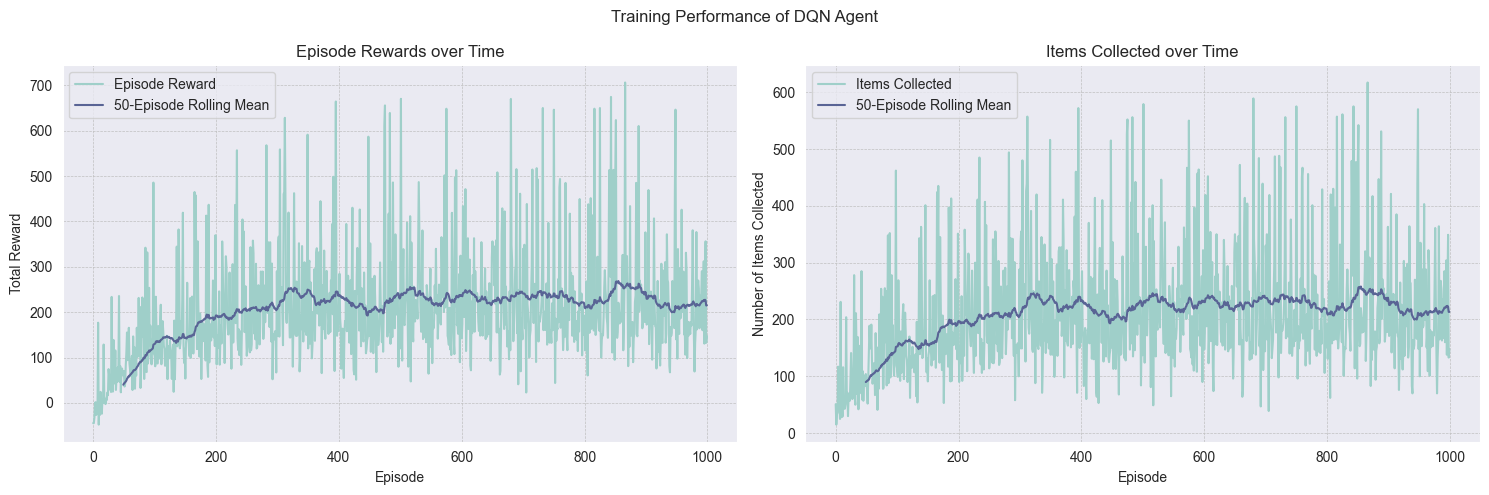

In [14]:
plot_learning_performance(results, rolling_mean=50, title="Training Performance of DQN Agent")

Agent Evaluation

In [15]:
env1 = gymnasium.make("cookiedisaster-v1", render_mode="rgb_array")
env2 = gymnasium.make("cookiedisaster-v2", render_mode="rgb_array")
env3 = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array")

In [16]:
agent.set_evaluation_mode(True)

In [17]:
def evaluate_agent(agent, env, num_episodes=200, max_steps_per_episode=2000):
    episode_rewards = []
    episode_items_collected = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        state = get_features(obs, info)
        state = normalize(state)

        episode_reward = 0
        items_collected = 0

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)
            next_obs, reward, _, _, next_info = env.step(action)
            state = get_features(next_obs, next_info)
            state = normalize(state)

            if reward == 1:
                items_collected += 1

            episode_reward += reward

        episode_rewards.append(episode_reward)
        episode_items_collected.append(items_collected)
        print(f"\rEpisode: {episode + 1}   Reward: {episode_reward:.3f}", end="")

    print(f"\n\nAverage Reward: {np.array(episode_rewards).mean():.3f}", )
    print(f"Average Number of Collected Items: {np.array(episode_items_collected).mean():.3f}")

    return {
        "episode_rewards": episode_rewards,
        "episode_items_collected": episode_items_collected
    }

DQN Agent Evaluation on `cookiedisaster-v1`, `cookiedisaster-v2` and `cookiedisaster-v3`

In [18]:
env1_eval_results = evaluate_agent(agent, env1)

Episode: 200   Reward: 280.547

Average Reward: 259.608
Average Number of Collected Items: 257.655


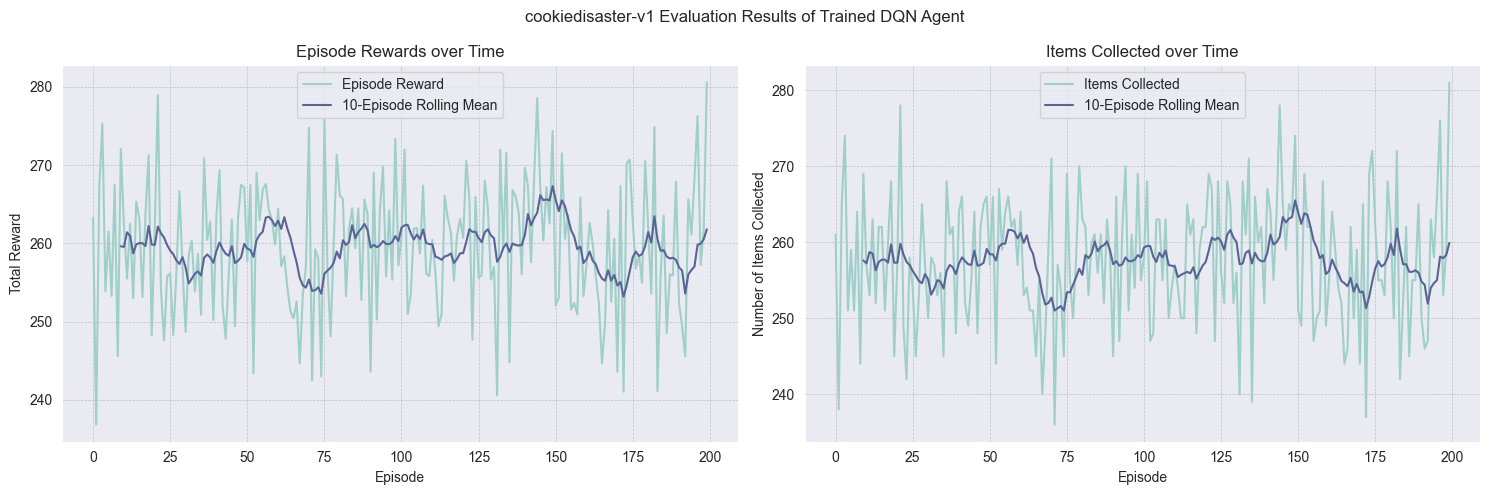

In [19]:
plot_learning_performance(env1_eval_results, rolling_mean=10,
                          title="cookiedisaster-v1 Evaluation Results of Trained DQN Agent")

In [20]:
env2_eval_results = evaluate_agent(agent, env2)

Episode: 200   Reward: 327.870

Average Reward: 349.569
Average Number of Collected Items: 339.670


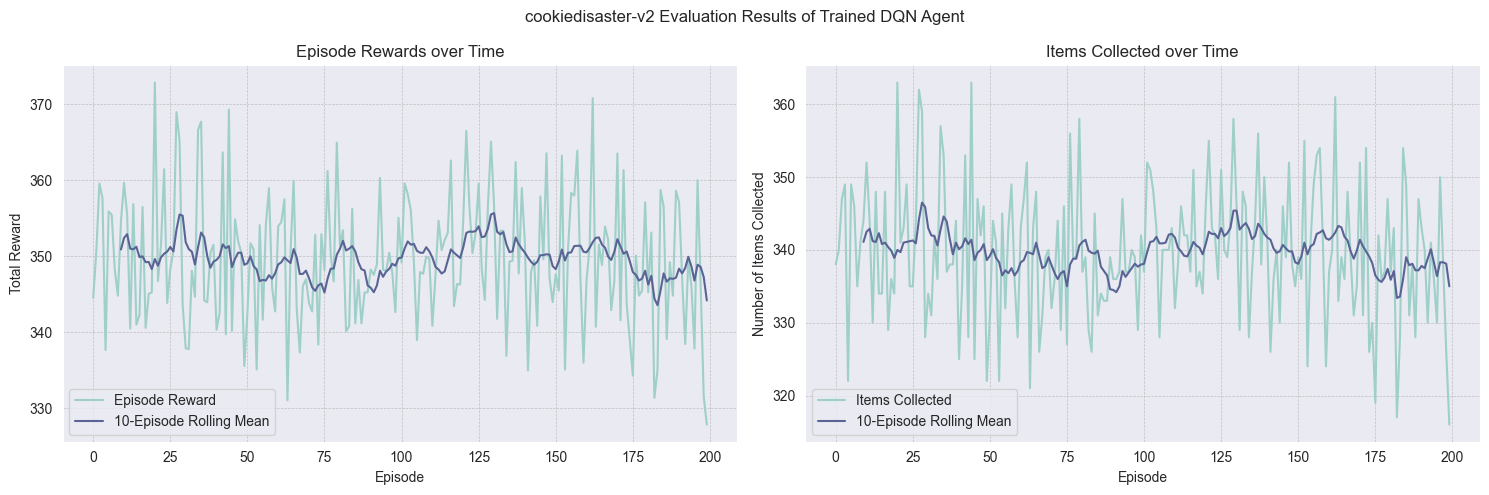

In [21]:
plot_learning_performance(env2_eval_results, rolling_mean=10,
                          title="cookiedisaster-v2 Evaluation Results of Trained DQN Agent")

In [22]:
env3_eval_results = evaluate_agent(agent, env3)

Episode: 200   Reward: 223.613

Average Reward: 235.681
Average Number of Collected Items: 232.680


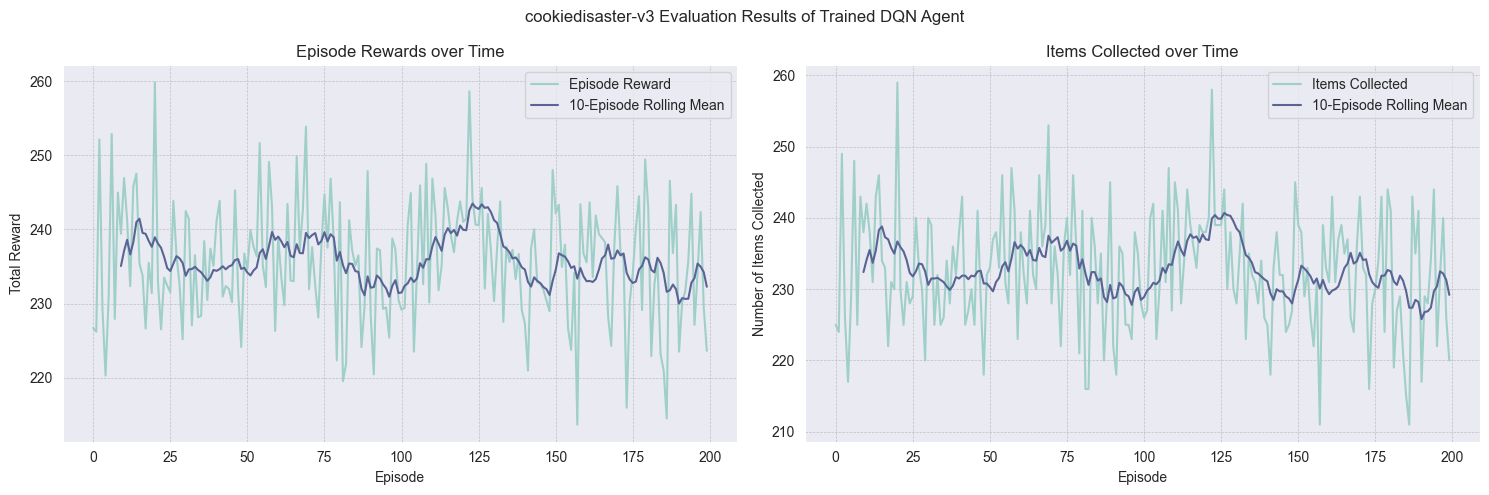

In [23]:
plot_learning_performance(env3_eval_results, rolling_mean=10,
                          title="cookiedisaster-v3 Evaluation Results of Trained DQN Agent")

DQN Agent Evaluation on Custom Environment

In [24]:
custom_config = {"img": "cake", "width": 18, "lifetime": 2, "friction": lambda vel: - abs(vel) * vel * 0.01}
custom_env = gymnasium.make("cookiedisaster-v3", render_mode="rgb_array", config=custom_config)

In [25]:
custom_env_eval_results = evaluate_agent(agent, custom_env)

Episode: 200   Reward: 107.235

Average Reward: 89.267
Average Number of Collected Items: 109.860


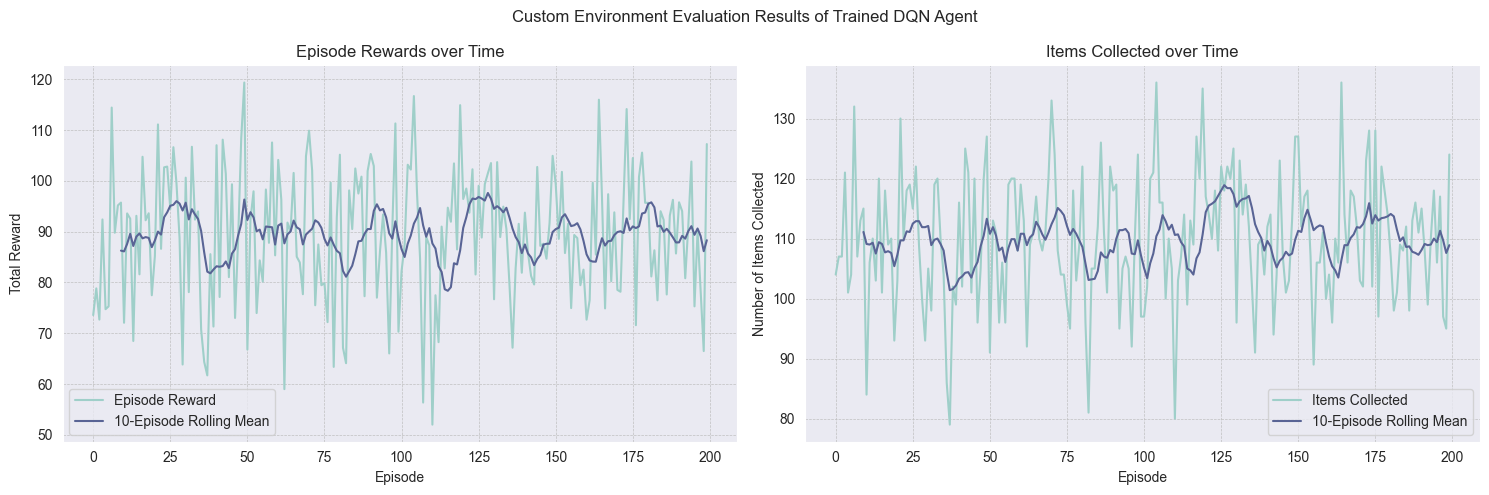

In [26]:
plot_learning_performance(custom_env_eval_results, rolling_mean=10,
                          title="Custom Environment Evaluation Results of Trained DQN Agent")